<a href="https://colab.research.google.com/github/psahai10/AIFellowship/blob/main/Uplift_modelling_pylift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/W-Tran/uplift-modelling/blob/master/Uplift_Modelling.ipynb

http://minethatdata.com/Stochastic_Solutions_E-Mail_Challenge_2008.04.30.pdf

In [158]:
! pip install pylift

In [159]:
data = 'https://raw.githubusercontent.com/W-Tran/uplift-modelling/master/data/hillstrom/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv'

%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylift import TransformedOutcome
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,  train_test_split, GridSearchCV
from scipy.stats import uniform, reciprocal, t
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
# from uplift.plot_functions import compute_treatment_effect, compute_visit_rates, cumulative_treatment_effect
# from uplift.print_ate import *
plt.style.use('fivethirtyeight')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [161]:
df = pd.read_csv('/content/drive/My Drive/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [ ]:
df.history_segment = df.history_segment.map({'1) $0 - $100': 0, '2) $100 - $200': 1, '3) $200 - $350': 2,
                                 '4) $350 - $500': 3, '5) $500 - $750':4, '6) $750 - $1,000': 5,
                                 '7) $1,000 +':6})

df.segment = df.segment.map({'Womens E-Mail': 1, 'Mens E-Mail':1, 'No E-Mail': 0})
df.zip_code = df.zip_code.map({'Surburban': 0, 'Rural': 1, 'Urban':2})
df.channel = df.channel.map({'Phone': 0, 'Web': 1, 'Multichannel':2})

In [ ]:
df.rename(columns={'visit':'target', 'segment':'treatment'}, inplace=True)

In [ ]:
features = list(df.columns)

In [ ]:
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target,conversion,spend
0,10,1,142.44,1,0,0,0,0,1,0,0,0.0
1,6,2,329.08,1,1,1,1,1,0,0,0,0.0
2,7,1,180.65,0,1,0,1,1,1,0,0,0.0
3,9,4,675.83,1,0,1,1,1,1,0,0,0.0
4,2,0,45.34,1,0,2,0,1,1,0,0,0.0


# Method 1: Sklearn xgb boost
1. Method 1a: Two classes and promotions to everyone.
2. Method 2b: 4 classes and promotions to top people.
    a. Control Non-responders (lost causes)
    b. Control responders (pursuadables)
    c. Treatment Non-responders (do not disturb)
    d. Treatment responders (sure thing)

In [ ]:
def score(df, promo_pred_col = 'treatment'):
    n_treat       = df.loc[df[promo_pred_col] != 0,:].shape[0]
    n_control     = df.loc[df[promo_pred_col] == 0,:].shape[0]
    n_treat_purch = df.loc[df[promo_pred_col] == 1, 'target'].sum()
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 0, 'target'].sum()
    print(n_treat, n_control)
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    # nir = 11 * n_treat_purch - 3 * n_treat + 11 * n_ctrl_purch
    return (irr, nir)

In [ ]:
def test_results(promotion_strategy, test_data, features):
    df = test_data[features]
    promos = promotion_strategy(df)
    score_df = test_data.iloc[np.where(promos == 1)]
    irr, nir = score(score_df)
    print('Your irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    return irr, nir

In [ ]:

# added this function to test our irr and nlr on the validation set
def valid_results(promotion_strategy, valid_data, features):
    df = valid_data[features]
    promos = promotion_strategy(df)
    score_df = valid_data.iloc[np.where(promos == 1)]    
    irr, nir = score(score_df)
    print('Your irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    return irr, nir

In [ ]:
def promotion_strategy(df):
    test = df
    promotion = []
    num_test_points = test.shape[0]
    for i in range(num_test_points):
        promotion.append(1)
    promotion = np.array(promotion)
    return promotion

In [ ]:
Train, test, Train_target, test_target = train_test_split(df.drop(['target'], axis=1), df.target, test_size=0.1, stratify=df.target, random_state=42)
df_train = pd.concat([Train, Train_target], axis=1)
df_test = pd.concat([test, test_target], axis=1)

print(len(df_train))
print(len(df_test))
features = ['recency', 'history', 'zip_code', 'newbie', 'channel' , 'treatment', 'target']

57600
6400


In [ ]:
df_temp_train = df_train
response = []

for index, row in df_temp_train.iterrows():
    if (row['target'] == 1) and (row['treatment']==1):
        response.append(1.0)
    else:
        response.append(0.0)
        
df_temp_train['response'] = response
df_temp_train.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,conversion,spend,target,response
10954,12,2,249.19,1,0,0,0,2,0,0,0.0,0,0.0
39682,10,1,104.04,1,0,2,0,1,1,0,0.0,0,0.0
521,1,6,1515.82,1,1,0,1,2,1,1,499.0,1,1.0
15569,2,0,29.99,1,0,0,1,0,1,0,0.0,0,0.0
31460,12,0,29.99,1,0,0,0,1,1,0,0.0,0,0.0


In [ ]:
df_temp_test = df_test
response = []

for index, row in df_temp_test.iterrows():
    if (row['target'] == 1) and (row['treatment']==1):
        response.append(1.0)
    else:
        response.append(0.0)
        
df_temp_test['response'] = response
df_temp_test.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,conversion,spend,target,response
51442,1,0,44.44,1,0,2,0,1,1,0,0.0,0,0.0
43858,6,2,332.03,1,1,2,0,1,1,0,0.0,0,0.0
6211,1,1,165.36,0,1,2,0,1,1,0,0.0,0,0.0
31803,7,0,66.36,1,0,2,1,0,1,0,0.0,0,0.0
30885,1,2,244.58,1,0,2,1,0,0,0,0.0,0,0.0


In [ ]:
train, valid = train_test_split(df_temp_train, test_size=0.2,random_state=42, stratify=df_temp_train.target)
print(len(train))
print(len(valid))

46080
11520


In [ ]:
y_values = ['treatment', 'target', 'response']
features_n = list(X_train.columns)
features = list(filter(lambda x: x not in y_values, features_n))

In [ ]:
# generate features and labels
Y_train = train['response']
X_train = train[features]

Y_valid = valid['response']
X_valid = valid[features]

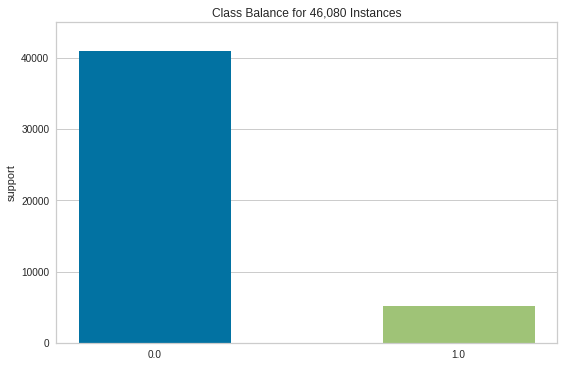

In [ ]:
from yellowbrick.target import class_balance

class_balance(Y_train);

In [ ]:
# up sample only the train dataset with SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


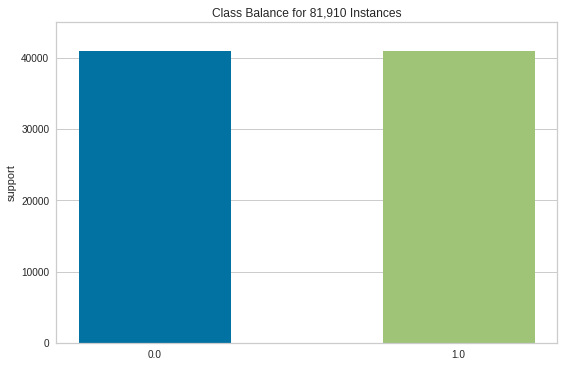

In [ ]:
class_balance(Y_train_upsamp);

In [ ]:
# Train an xgboost model
import xgboost as xgb
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.849944	validation_1-auc:0.538165
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.854179	validation_1-auc:0.542317
[2]	validation_0-auc:0.863219	validation_1-auc:0.548359
[3]	validation_0-auc:0.870969	validation_1-auc:0.549762
[4]	validation_0-auc:0.875071	validation_1-auc:0.551793
[5]	validation_0-auc:0.880079	validation_1-auc:0.550424
[6]	validation_0-auc:0.881777	validation_1-auc:0.549496
[7]	validation_0-auc:0.882743	validation_1-auc:0.549971
[8]	validation_0-auc:0.887848	validation_1-auc:0.551245
[9]	validation_0-auc:0.887996	validation_1-auc:0.552453
[10]	validation_0-auc:0.89066	validation_1-auc:0.552663
[11]	validation_0-auc:0.895762	validation_1-auc:0.551506
[12]	validation_0-auc:0.898682	validation_1-auc:0.55037
[13]	validation_0-auc:0.899629	validation_1-auc:0.551193
[14]	validation_0-auc:0.902043	validation_1-auc:0.550528


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

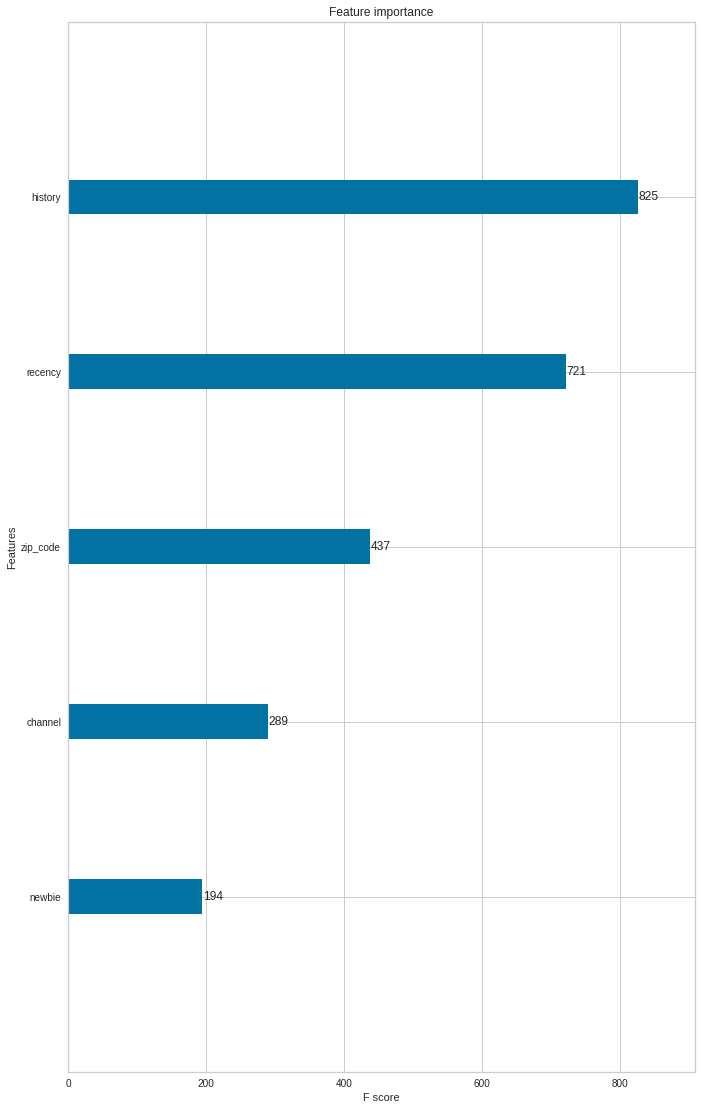

In [ ]:
# check which features are important

from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

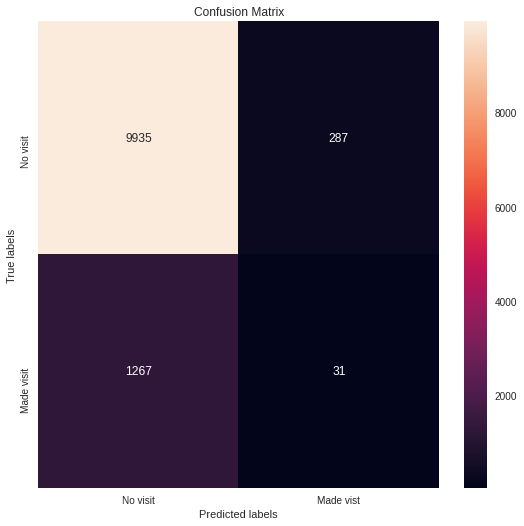

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No visit', 'Made vist']); 
ax.yaxis.set_ticklabels(['No visit', 'Made visit']);

In [ ]:
def promotion_strategy(df):
    test = df
    preds = model.predict(test, ntree_limit=model.best_ntree_limit)

    promotion = []
    for pred in preds:
        if pred == 1:
         promotion.append(1)
        else:
          promotion.append(0)
    promotion = np.array(promotion)
    return promotion

In [ ]:
valid_results(promotion_strategy, valid, features)

207 111
Your irr with this strategy is 0.0417.

Your nir with this strategy is 158.95.


(0.04165034599817208, 158.95)

In [ ]:
valid_results(promotion_strategy, df_temp_test, features)

115 57
Your irr with this strategy is -0.0366.

Your nir with this strategy is 62.75.


(-0.03661327231121281, 62.75)

In [ ]:
train, valid = train_test_split(df_train, test_size=0.2,random_state=42, stratify=df_train.target)
print(len(train))
print(len(valid))

46080
11520


In [ ]:
target = []
for index, row in train.iterrows():
    if (row['treatment'] == 1) & (row['target'] == 1):
        # TR group
        target.append(0)
    elif (row['treatment'] == 0) & (row['target'] == 1):
        # CR group
        target.append(1)
    elif (row['treatment'] == 1) & (row['target'] == 0):
        # TN group
        target.append(2)
    else: #CN group
        target.append(3)
train['target'] = target

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
target = []
for index, row in valid.iterrows():
    if (row['treatment'] == 1) & (row['target'] == 1):
        # TR group
        target.append(0)
    elif (row['treatment'] == 0) & (row['target'] == 1):
        # CR group
        target.append(1)
    elif (row['treatment'] == 1) & (row['target'] == 0):
        # TN group
        target.append(2)
    else: #CN group
        target.append(3)

valid['target'] = target

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


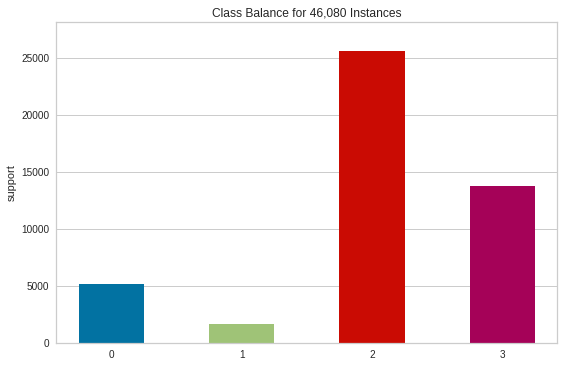

In [ ]:
class_balance(train['target']);

In [ ]:
y_values = ['treatment', 'target', 'response']
features_n = list(X_train.columns)
features = list(filter(lambda x: x not in y_values, features_n))

In [ ]:
#features = ['recency', 'history', 'zip_code', 'newbie', 'channel' ]#, 'treatment', 'target']

Y_train = train['target']
X_train = train[features]

Y_valid = valid['target']
X_valid = valid[features]

In [ ]:
# up sample with SMOTE
sm = SMOTE({0:25572, 1:25572, 2:25572, 3:25572}, random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)
Y_train_upsamp.value_counts()

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (25572) in class 0 will be larger than the number of samples in the majority class (class #2 -> 25560)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (25572) in class 1 will be larger than the number of samples in the majority class (class #2 -> 25560)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (25572) in class 2 will be larger than the number of samples in the majority class (class #2 -> 25560)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (25572) in class 3 will be larger than the number of samples in the majority class (class #2 -> 25560)

3    25572
2    25572
1    25572
0    25572
dtype: int64

In [ ]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          num_class=4,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'multi:softmax',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="mlogloss", verbose=True, early_stopping_rounds=30)

[0]	validation_0-mlogloss:1.35867	validation_1-mlogloss:1.36216
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.33398	validation_1-mlogloss:1.3407
[2]	validation_0-mlogloss:1.31228	validation_1-mlogloss:1.32148
[3]	validation_0-mlogloss:1.29319	validation_1-mlogloss:1.30454
[4]	validation_0-mlogloss:1.2759	validation_1-mlogloss:1.28895
[5]	validation_0-mlogloss:1.26044	validation_1-mlogloss:1.27532
[6]	validation_0-mlogloss:1.24662	validation_1-mlogloss:1.26268
[7]	validation_0-mlogloss:1.23364	validation_1-mlogloss:1.25114
[8]	validation_0-mlogloss:1.22216	validation_1-mlogloss:1.2412
[9]	validation_0-mlogloss:1.21106	validation_1-mlogloss:1.23154
[10]	validation_0-mlogloss:1.20079	validation_1-mlogloss:1.22245
[11]	validation_0-mlogloss:1.19167	validation_1-mlogloss:1.2148
[12]	validation_0-mlogloss:1.1829	validation_1-mlogloss:1.20725
[13

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=True, subsample=1, verbosity=1)

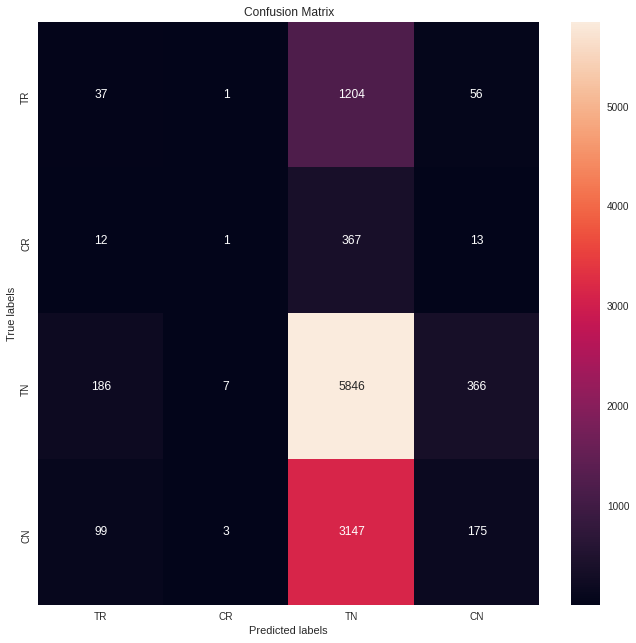

In [ ]:
# confusion marix for thge validation set
# Note:
# TR: treatment and respond group (received promotion and made purchase)
# CR: control and respond group (did not receive promotion but made purchase)
# TN: treatment and no respond group (received promotion but did not made purchase)
# CR: control and no respond group (did not receive promotion and made no purchase)
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']); 
ax.yaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']);

In [ ]:
def promotion_strategy(df):
    test = df
    pred = model.predict(test, ntree_limit=model.best_ntree_limit)
    promotion = []
    for pred in pred:
        if pred == 0:
            promotion.append(1)
        else:
            promotion.append(0)
    promotion = np.array(promotion)
    return promotion

In [ ]:
valid_results(promotion_strategy, valid, features)

223 111
Your irr with this strategy is -1.1156.

Your nir with this strategy is 596.55.


(-1.1156223488062054, 596.5500000000002)

In [ ]:
df_temp_test = df_test
target = []
for index, row in df_temp_test.iterrows():
    if (row['treatment'] == 1) & (row['target'] == 1):
        # TR group
        target.append(0)
    elif (row['treatment'] == 0) & (row['target'] == 1):
        # CR group
        target.append(1)
    elif (row['treatment'] == 1) & (row['target'] == 0):
        # TN group
        target.append(2)
    else: #CN group
        target.append(3)

df_temp_test['target'] = target

In [ ]:
valid_results(promotion_strategy, df_temp_test, features)

113 57
Your irr with this strategy is -1.0037.

Your nir with this strategy is 293.05.


(-1.0037261294829996, 293.04999999999995)

# Method 2: Pylift

In [ ]:
def visit_rate_ate(df, test_set=False):
    if test_set:
        treatment_visit_rate = df[df.Treatment == 1].Outcome.mean() * 100
        control_visit_rate = df[df.Treatment == 0].Outcome.mean() * 100
        average_treatment_effect = treatment_visit_rate - control_visit_rate
        print("Test set visit rate uplift: {:.2f}%".format(average_treatment_effect))
        return average_treatment_effect
    else:
        mens = df[df.segment == "Mens E-Mail"].visit.mean() * 100
        womens = df[df.segment == "Womens E-Mail"].visit.mean() * 100
        control = df[df.segment == "No E-Mail"].visit.mean() * 100
        print("Men's E-Mail visit rate: {:.2f}%".format(mens))
        print("Women's E-Mail visit rate: {:.2f}%".format(womens))
        print("Control E-mail visit Rate: {:.2f}%".format(control))
        print("---------------------------------")
        print("Men's visit rate uplift: {:.2f}%".format(mens - control))
        print("Women's visit rate uplift: {:.2f}%".format(womens - control))


def conversion_rate_ate(df):
    mens = df[df.segment == "Mens E-Mail"].conversion.mean() * 100
    womens = df[df.segment == "Womens E-Mail"].conversion.mean() * 100
    control = df[df.segment == "No E-Mail"].conversion.mean() * 100
    print("Men's E-Mail conversion rate: {:.2f}%".format(mens))
    print("Women's E-Mail conversion rate: {:.2f}%".format(womens))
    print("Control E-mail conversion Rate: {:.2f}%".format(control))
    print("---------------------------------")
    print("Men's conversion rate uplift: {:.2f}%".format(mens - control))
    print("Women's conversion rate uplift: {:.2f}%".format(womens - control))


def spending_ate(df):
    mens = df[df.segment == "Mens E-Mail"].spend.mean()
    womens = df[df.segment == "Womens E-Mail"].spend.mean()
    control = df[df.segment == "No E-Mail"].spend.mean()
    print("Men's E-Mail spending: ${:.2f}".format(mens))
    print("Women's E-Mail spending: ${:.2f}".format(womens))
    print("Control E-mail spending: ${:.2f}".format(control))
    print("---------------------------------")
    print("Men's spending uplift: ${:.2f}".format(mens - control))
    print("Women's spending uplift: ${:.2f}".format(womens - control))


def spend_given_purchase(df):
    print("Men's average spend given purchase: ${:.2f}".format(
        df[(df.conversion == 1) & (df.segment == 'Mens E-Mail')].spend.mean()))
    print("Women's average spend given purchase: ${:.2f}".format(
        df[(df.conversion == 1) & (df.segment == 'Womens E-Mail')].spend.mean()))
    print("Control average spend given purchase: ${:.2f}".format(
        df[(df.conversion == 1) & (df.segment == 'No E-Mail')].spend.mean()))


def purchase_given_visit(df):
    print("Men's purchase rate given visit: {:.2f}%".format(100 * (
            len(df[(df.conversion == 1) & (df.segment == 'Mens E-Mail')]) / len(
        df[(df.visit == 1) & (df.segment == 'Mens E-Mail')]))))
    print("Women's purchase rate given visit: {:.2f}%".format(100 * (
            len(df[(df.conversion == 1) & (df.segment == 'Womens E-Mail')]) / len(
        df[(df.visit == 1) & (df.segment == 'Womens E-Mail')]))))
    print("Control purchase rate given visit: {:.2f}%".format(100 * (
            len(df[(df.conversion == 1) & (df.segment == 'No E-Mail')]) / len(
        df[(df.visit == 1) & (df.segment == 'No E-Mail')]))))


def visit_rate(df):
    print("Men's visit rate: {:.2f}%".format(
        100 * (len(df[(df.visit == 1) & (df.segment == 'Mens E-Mail')]) / len(df[(df.segment == 'Mens E-Mail')]))))
    print("Women's visit rate: {:.2f}%".format(
        100 * (len(df[(df.visit == 1) & (df.segment == 'Womens E-Mail')]) / len(df[(df.segment == 'Womens E-Mail')]))))
    print("Control visit rate: {:.2f}%".format(
        100 * (len(df[(df.visit == 1) & (df.segment == 'No E-Mail')]) / len(df[(df.segment == 'No E-Mail')]))))


def spend_per_head(df):
    print("Men's mean spend: ${:.2f}".format(df[(df.segment == 'Mens E-Mail')].spend.mean()))
    print("Women's mean spend: ${:.2f}".format(df[(df.segment == 'Womens E-Mail')].spend.mean()))
    print("Control mean spend: ${:.2f}".format(df[(df.segment == 'No E-Mail')].spend.mean()))

In [359]:
df = pd.read_csv('/content/drive/My Drive/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [360]:
# visit_rate_ate(df)
# print()
# conversion_rate_ate(df)
# print()
# spending_ate(df)

In [361]:

# spend_given_purchase(df)
# print()
# purchase_given_visit(df)
# print()
# visit_rate(df)
# print()
# spend_per_head(df)

In [362]:
df.history_segment = df.history_segment.map({'1) $0 - $100': 0, '2) $100 - $200': 1, '3) $200 - $350': 2,
                                 '4) $350 - $500': 3, '5) $500 - $750':4, '6) $750 - $1,000': 5,
                                 '7) $1,000 +':6})
df.zip_code = df.zip_code.map({'Surburban':0, 'Rural':1, 'Urban':2})
df.channel = df.channel.map({'Phone':0, 'Web':1, 'Multichannel':2})
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,1,142.44,1,0,0,0,0,Womens E-Mail,0,0,0.0
1,6,2,329.08,1,1,1,1,1,No E-Mail,0,0,0.0
2,7,1,180.65,0,1,0,1,1,Womens E-Mail,0,0,0.0
3,9,4,675.83,1,0,1,1,1,Mens E-Mail,0,0,0.0
4,2,0,45.34,1,0,2,0,1,Womens E-Mail,0,0,0.0


In [363]:
womens_df = df[df.segment!='Mens E-Mail'].copy()
womens_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,1,142.44,1,0,0,0,0,Womens E-Mail,0,0,0.0
1,6,2,329.08,1,1,1,1,1,No E-Mail,0,0,0.0
2,7,1,180.65,0,1,0,1,1,Womens E-Mail,0,0,0.0
4,2,0,45.34,1,0,2,0,1,Womens E-Mail,0,0,0.0
5,6,1,134.83,0,1,0,0,0,Womens E-Mail,1,0,0.0


In [364]:
womens_df.segment.replace({'Womens E-Mail':1, 'No E-Mail':0}, inplace=True)
womens_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,1,142.44,1,0,0,0,0,1,0,0,0.0
1,6,2,329.08,1,1,1,1,1,0,0,0,0.0
2,7,1,180.65,0,1,0,1,1,1,0,0,0.0
4,2,0,45.34,1,0,2,0,1,1,0,0,0.0
5,6,1,134.83,0,1,0,0,0,1,1,0,0.0


In [365]:
womens_df.drop(columns=['conversion', 'spend'], inplace=True)

In [366]:
womens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)
# from sklearn.preprocessing import LabelEncoder
# zip_code_le, channel_le = LabelEncoder(), LabelEncoder()
# womens_df.zip_code = zip_code_le.fit_transform(womens_df.zip_code)
# womens_df.channel = channel_le.fit_transform(womens_df.channel)
# womens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)
# womens_df.head()

In [367]:
# womens_df.drop(columns=['spend_segment_0', 'spend_segment_1', 'spend_segment_2',
#                         'spend_segment_3', 'spend_segment_4', 'spend_segment_5'], inplace=True)
womens_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,Treatment,Outcome
0,10,1,142.44,1,0,0,0,0,1,0
1,6,2,329.08,1,1,1,1,1,0,0
2,7,1,180.65,0,1,0,1,1,1,0
4,2,0,45.34,1,0,2,0,1,1,0
5,6,1,134.83,0,1,0,0,0,1,1


In [369]:
Train, test, Train_target, test_target = train_test_split(womens_df.drop(['Outcome'], axis=1), 
                                                          womens_df.Outcome, test_size=0.0001, 
                                                          stratify=womens_df.Outcome, 
                                                          random_state=42)
df_train = pd.concat([Train, Train_target], axis=1)
df_test = pd.concat([test, test_target], axis=1)

print(len(df_train))
print(len(df_test))

42688
5


In [370]:
features = list(df_train.columns)

In [371]:
def score(df, promo_pred_col = 'Treatment'):
    n_treat       = df.loc[df[promo_pred_col] != 0,:].shape[0]
    n_control     = df.loc[df[promo_pred_col] == 0,:].shape[0]
    n_treat_purch = df.loc[df[promo_pred_col] == 1, 'Outcome'].sum()
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 0, 'Outcome'].sum()
    print(n_treat, n_control)
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    #nir = 11 * n_treat_purch - 3 * n_treat - 11 * n_ctrl_purch
    return (irr, nir)

In [372]:
def test_results(promotion_strategy, test_data, features):
    df = test_data[features]
    promos = promotion_strategy(df)
    score_df = test_data.iloc[np.where(promos == 'Yes')]
    irr, nir = score(score_df)
    print('Your irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    return irr, nir

In [373]:

# added this function to test our irr and nlr on the validation set
def valid_results(promotion_strategy, valid_data, features):
    df = valid_data[features]
    promos = promotion_strategy(df)
    score_df = valid_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = score(score_df)
    print('Your irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('Your nir with this strategy is {:0.2f}.'.format(nir))
    return irr, nir

In [176]:
# def promotion_strategy(df):
#     test = df
#     promotion = []
#     num_test_points = test.shape[0]
#     for i in range(num_test_points):
#         promotion.append('Yes')
#     promotion = np.array(promotion)
#     return promotion

In [177]:
# test_results(promotion_strategy, df_train, features)

19262 19161
Your irr with this strategy is 0.0449.

Your nir with this strategy is 5870.70.


(0.044920710266449004, 5870.700000000001)

In [178]:
# test_results(promotion_strategy, df_test, features)

2125 2145
Your irr with this strategy is 0.0480.

Your nir with this strategy is 681.25.


(0.04804607157548335, 681.25)

In [295]:
df_train

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,Treatment,Outcome
39555,7,3,492.21,1,0,2,0,1,1,0
18780,2,1,168.98,0,1,0,1,0,0,0
49254,6,3,466.35,1,0,0,0,2,0,0
12958,11,3,384.04,0,1,0,0,1,1,1
11090,6,3,409.04,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
20619,10,0,49.97,1,0,2,1,1,0,0
52345,2,4,503.90,1,0,1,1,2,1,0
21507,4,4,716.31,1,1,2,1,0,0,0
41170,6,0,41.65,0,1,0,1,0,0,0


# -----------------------
# Path to balanced unbalanced data. Results don't loo as its working.

In [374]:
# response = []

# for index, row in df_train.iterrows():
#     if (row['Outcome'] == 1) and (row['Treatment']==1):
#         response.append(1.0)
#     else:
#         response.append(0.0)
        
# df_train['response'] = response
# df_train

response = []
for index, row in df_train.iterrows():
    if (row['Treatment'] == 1) & (row['Outcome'] == 1):
        # TR group
        response.append(0)
    elif (row['Treatment'] == 0) & (row['Outcome'] == 1):
        # CR group
        response.append(1)
    elif (row['Treatment'] == 1) & (row['Outcome'] == 0):
        # TN group
        response.append(2)
    else: #CN group
        response.append(3)

df_train['response'] = response

In [375]:
train, valid = train_test_split(df_train, test_size=0.001,
                                random_state=42, 
                                stratify=df_train.Outcome)

In [376]:
y_not_to_include = ['response']
list_of_total_features = list(train.columns)
features = list(filter(lambda x: x not in y_not_to_include, list_of_total_features))
features

['recency',
 'history_segment',
 'history',
 'mens',
 'womens',
 'zip_code',
 'newbie',
 'channel',
 'Treatment',
 'Outcome']

In [377]:
# generate features and labels
Y_train = train['response']
X_train = train[features]

Y_valid = valid['response']
X_valid = valid[features]

In [378]:
X_train

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,Treatment,Outcome
23170,2,1,172.46,1,0,2,0,0,1,0
41062,9,0,70.86,1,0,2,0,1,0,0
35115,3,0,41.19,1,0,2,1,1,0,0
34327,2,1,125.66,1,0,0,0,1,0,0
19371,2,0,82.52,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
36144,1,0,29.99,0,1,2,1,1,0,0
1795,3,1,102.08,0,1,1,0,1,0,0
10196,9,2,285.20,0,1,1,0,0,1,0
19681,2,0,54.74,0,1,2,0,0,1,0


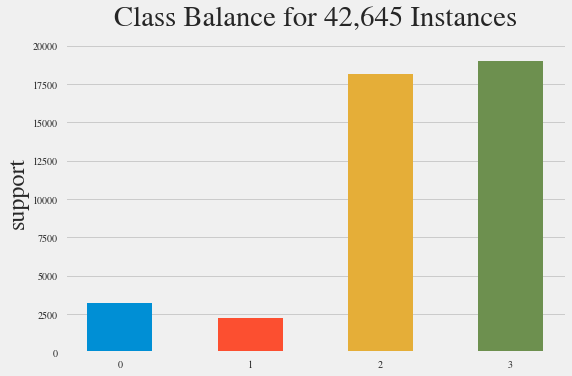

In [379]:
from yellowbrick.target import class_balance

class_balance(Y_train);

In [380]:
# up sample with SMOTE
from imblearn.over_sampling import SMOTENC
# up sample only the train dataset with SMOTE
# sm = SMOTENC(categorical_features=[1,3,4,5,6,7,8,9,10,11,12], random_state=42)#, ratio = 1.0)
sm = SMOTENC(categorical_features=[1,3,4,5,6,7,8], random_state=42)#, ratio = 1.0)

# sm = SMOTE({0:18572, 1:18572, 2:18572, 3:18572}, random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)
Y_train_upsamp.value_counts()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


3    19023
2    19023
1    19023
0    19023
dtype: int64

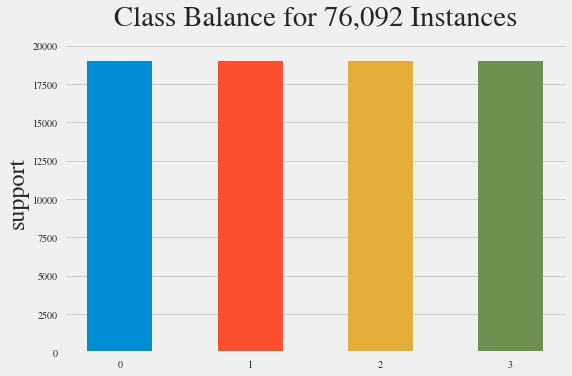

In [381]:
class_balance(Y_train_upsamp);

In [382]:
womens_df = pd.concat([X_train_upsamp, Y_train_upsamp], axis=1)
del womens_df[0]
womens_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,Treatment,Outcome
0,2.0,1.0,172.46,1.0,0.0,2.0,0.0,0.0,1.0,0.0
1,9.0,0.0,70.86,1.0,0.0,2.0,0.0,1.0,0.0,0.0
2,3.0,0.0,41.19,1.0,0.0,2.0,1.0,1.0,0.0,0.0
3,2.0,1.0,125.66,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.0,0.0,82.52,1.0,0.0,1.0,1.0,1.0,1.0,0.0


In [383]:
# del womens_df['Outcome']

In [384]:

# womens_df.rename(columns={0:'Outcome'}, inplace=True)

In [385]:
womens_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,Treatment,Outcome
0,2.0,1.0,172.46,1.0,0.0,2.0,0.0,0.0,1.0,0.0
1,9.0,0.0,70.86,1.0,0.0,2.0,0.0,1.0,0.0,0.0
2,3.0,0.0,41.19,1.0,0.0,2.0,1.0,1.0,0.0,0.0
3,2.0,1.0,125.66,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2.0,0.0,82.52,1.0,0.0,1.0,1.0,1.0,1.0,0.0


In [386]:
from pylift import TransformedOutcome
from sklearn.ensemble import RandomForestRegressor
state = 18

up1 = TransformedOutcome(womens_df,
                         col_treatment='Treatment',
                         col_outcome='Outcome',
                         stratify=womens_df['Treatment'],
                         test_size=0.5,
                         continuous_outcome=False,
                         sklearn_model=RandomForestRegressor,
                         random_state=state
                        )

In [387]:
# best_params = {
#     'random_state': state,  # 18
#     'n_estimators': 22,
#     'min_samples_split': 6079,
#     'max_depth': 7
# }
# up1.fit(**best_params)

up1.randomized_search(param_distributions={
    'n_estimators': [10,50, 100, 125, 150, 200],
    'max_depth':[2,3,5,8,10,20],
    'min_samples_split':[10, 50, 100,1000,5000,10000],
    'max_features':['auto']}, refit=True)
up1.fit(**up1.rand_search_.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=200, min_samples_split=5000, max_features=auto, max_depth=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_split=5000, max_features=auto, max_depth=8, score=0.078, total=   3.7s
[CV] n_estimators=200, min_samples_split=5000, max_features=auto, max_depth=8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=5000, max_features=auto, max_depth=8, score=0.096, total=   3.5s
[CV] n_estimators=200, min_samples_split=5000, max_features=auto, max_depth=8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=5000, max_features=auto, max_depth=8, score=0.087, total=   3.6s
[CV] n_estimators=200, min_samples_split=5000, max_features=auto, max_depth=8 
[CV]  n_estimators=200, min_samples_split=5000, max_features=auto, max_depth=8, score=0.074, total=   3.3s
[CV] n_estimators=200, min_samples_split=5000, max_features=auto, max_depth=8 
[CV]  n_estimators=200, min_samples_split=5000, max_features=auto, max_depth=8, score=0.069, total=   3.3s
[CV] n_estimators=125, min_samples_split=50, max_features=auto, max_depth=2 
[CV]  n_estimators=125, min_samples_split=50, max_features=auto, max_depth=2, score=0.069, total=   1.7s
[CV] n_estimators=125, min_samples_split=50, max_features=auto, max_depth=2 
[CV]  n_estimators=125, min_samples_split=50, max_features=auto, max_depth=2, score=0.079, total=   1.7s
[CV] n_estimators=125, min_samples_split=50, max_features=auto, max_depth=2 
[CV]  n_estimators=125, min_samples_split=50, max_features=auto, max_depth=2, sc

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.1min finished


In [388]:
up1.rand_search_.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_split': 10,
 'n_estimators': 50}

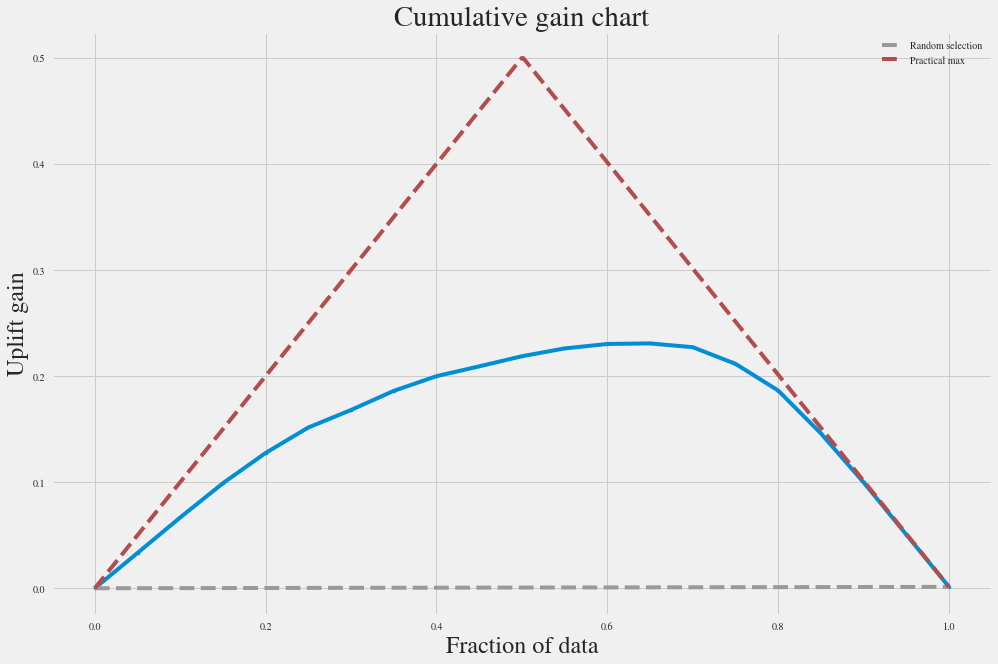

In [389]:
up1.plot(plot_type='cgains', show_practical_max=True)

Text(0.5, 1.0, 'Qini Curve (Test)')

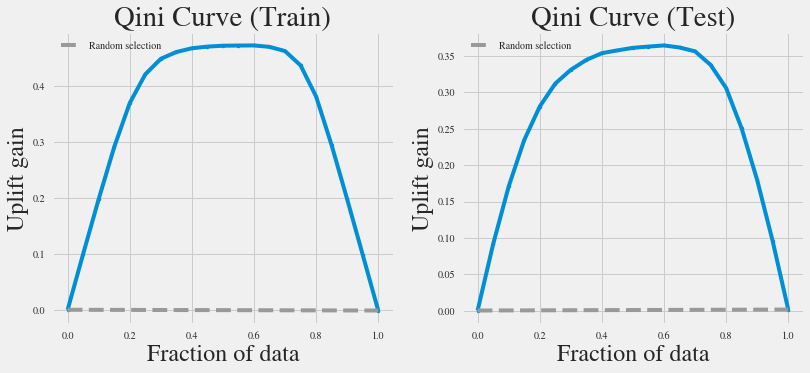

In [390]:

# Plot Train/Test Qini Curve
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
up1.train_results_.plot('qini', ax=ax, show_random_selection=True)
ax.set_title("Qini Curve (Train)")
ax = fig.add_subplot(122)
up1.test_results_.plot('qini', ax=ax, show_random_selection=True)
ax.set_title("Qini Curve (Test)")

In [391]:
def visit_rate_ate(df, test_set=False):
    if test_set:
        treatment_visit_rate = df[df.Treatment == 1].Outcome.mean() * 100
        control_visit_rate = df[df.Treatment == 0].Outcome.mean() * 100
        average_treatment_effect = treatment_visit_rate - control_visit_rate
        print("Test set visit rate uplift: {:.2f}%".format(average_treatment_effect))
        return average_treatment_effect
    else:
        mens = df[df.segment == "Mens E-Mail"].visit.mean() * 100
        womens = df[df.segment == "Womens E-Mail"].visit.mean() * 100
        control = df[df.segment == "No E-Mail"].visit.mean() * 100
        print("Men's E-Mail visit rate: {:.2f}%".format(mens))
        print("Women's E-Mail visit rate: {:.2f}%".format(womens))
        print("Control E-mail visit Rate: {:.2f}%".format(control))
        print("---------------------------------")
        print("Men's visit rate uplift: {:.2f}%".format(mens - control))
        print("Women's visit rate uplift: {:.2f}%".format(womens - control))

In [392]:
average_treatment_effect = visit_rate_ate(up1.df_test, test_set=True)
print("Qini AUC: {:.5f}".format(up1.train_results_.Q_qini))
print("Qini AUC: {:.5f}".format(up1.test_results_.Q_qini))

Test set visit rate uplift: 0.13%
Qini AUC: 0.35141
Qini AUC: 0.27289


In [393]:
response_train_df = up1.df_train[up1.df_train.Treatment==1].copy()
response_test_df = up1.df_test.copy()

response_train_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)
response_test_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)

response_train_label = response_train_df.Outcome
response_test_label = response_test_df.Outcome
response_train_df = response_train_df.drop(columns='Outcome')
response_test_df = response_test_df.drop(columns='Outcome')

gs = GridSearchCV(
    RandomForestClassifier(n_estimators=1000),
    param_grid={'max_depth':[3,5,7,9,11]},
    scoring='accuracy',
    n_jobs=4,
    iid=False,
    cv=5
)
gs.fit(response_train_df, response_train_label)
response_model = RandomForestClassifier(n_estimators=1000, **gs.best_params_)
response_model.fit(response_train_df, response_train_label)
y_pred_response = response_model.predict_proba(response_test_df)[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [394]:
# Test set dataframe containing uplift/response scores scorted into deciles
results_df = up1.df_test.copy()
results_df['response'] = y_pred_response
results_df['uplift'] = up1.transformed_y_test_pred
results_df['response_decile'] = pd.qcut(y_pred_response, 10)
results_df['uplift_decile'] = pd.qcut(up1.transformed_y_test_pred, 10)

results_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,Treatment,Outcome,TransformedOutcome,response,uplift,response_decile,uplift_decile
71185,5.181841,1.0,137.346361,0.0,1.0,2.0,0.0,1.0,0.0,1.0,-2,0.517410,-1.725454,"(0.478, 0.535]","(-2.001, -1.223]"
40064,1.000000,2.0,344.090000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0.285413,0.028387,"(0.204, 0.286]","(-0.0776, 0.0402]"
35536,10.000000,4.0,647.260000,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0,0.455204,1.567098,"(0.42, 0.478]","(1.13, 2.0]"
8295,2.000000,0.0,29.990000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-2,0.578327,0.091319,"(0.535, 0.601]","(0.0402, 0.155]"
26831,9.000000,2.0,347.600000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0,0.400514,-0.175553,"(0.355, 0.42]","(-0.293, -0.0776]"


In [395]:
def compute_visit_rates(results_df, for_response=True):
    if for_response:
        targeting_strategy = 'response_decile'
    else:
        targeting_strategy = 'uplift_decile'

    treatment_group = results_df[results_df.Treatment == 1]
    control_group = results_df[results_df.Treatment == 0]

    treatment_visit_rates = (treatment_group.groupby(targeting_strategy)['Outcome'].mean() * 100).reset_index()
    control_visit_rates = (control_group.groupby(targeting_strategy)['Outcome'].mean() * 100).reset_index()

    treatment_visit_rates[targeting_strategy] = treatment_visit_rates[targeting_strategy].astype(str)
    control_visit_rates[targeting_strategy] = control_visit_rates[targeting_strategy].astype(str)

    treatment_visit_rates.columns = [targeting_strategy, 'visit_rate']
    control_visit_rates.columns = [targeting_strategy, 'visit_rate']

    return treatment_visit_rates, control_visit_rates

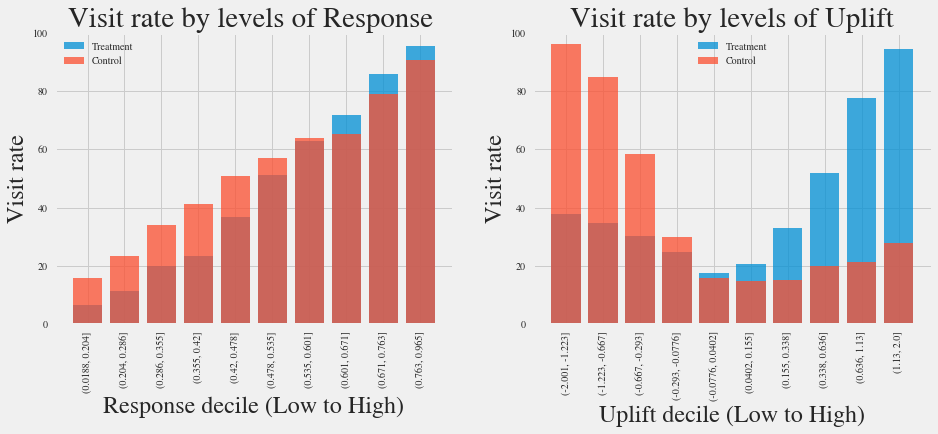

In [396]:
response_visit_rates_t, response_visit_rates_c = compute_visit_rates(results_df, for_response=True)
uplift_visit_rates_t, uplift_visit_rates_c = compute_visit_rates(results_df, for_response=False)

fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.bar(response_visit_rates_t['response_decile'], response_visit_rates_t['visit_rate'], label='Treatment', alpha=0.75)
ax1.bar(response_visit_rates_c['response_decile'], response_visit_rates_c['visit_rate'], label='Control', alpha=0.75)
ax1.set_ylabel("Visit rate")
ax1.set_xlabel("Response decile (Low to High)")
ax1.legend()
ax1.set_title("Visit rate by levels of Response ")
plt.xticks(rotation='vertical')
ax1.set_ylim(0,100)

ax2 = fig.add_subplot(122)
ax2.bar(uplift_visit_rates_t['uplift_decile'], uplift_visit_rates_t['visit_rate'], label='Treatment', alpha=0.75)
ax2.bar(uplift_visit_rates_c['uplift_decile'], uplift_visit_rates_c['visit_rate'], label='Control', alpha=0.75)
ax2.set_ylabel("Visit rate")
ax2.set_xlabel("Uplift decile (Low to High)")
ax2.legend()
ax2.set_title("Visit rate by levels of Uplift")
plt.xticks(rotation='vertical')
ax2.set_ylim(0,100);

del response_visit_rates_t, response_visit_rates_c, uplift_visit_rates_t, uplift_visit_rates_c

In [397]:

def compute_treatment_effect(results_df, for_response=True):
    if for_response:
        targeting_strategy = 'response_decile'
    else:
        targeting_strategy = 'uplift_decile'
    treatment_group = results_df[results_df.Treatment == 1]
    control_group = results_df[results_df.Treatment == 0]

    treatment_visit_rates = (treatment_group.groupby(targeting_strategy)['Outcome'].mean() * 100)
    control_visit_rates = (control_group.groupby(targeting_strategy)['Outcome'].mean() * 100)

    treatment_effect = (treatment_visit_rates - control_visit_rates).reset_index()
    treatment_effect[targeting_strategy] = treatment_effect[targeting_strategy].astype(str)
    treatment_effect.columns = [targeting_strategy, 'treatment_effect']
    return treatment_effect


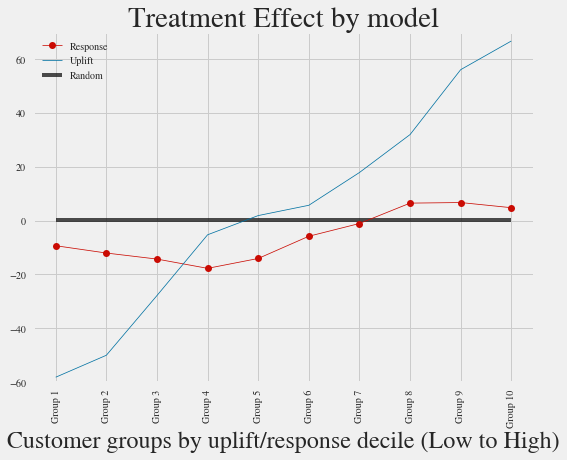

In [398]:
response_treatment_effect = compute_treatment_effect(results_df, for_response=True)
uplift_treatment_effect = compute_treatment_effect(results_df, for_response=False)
response_treatment_effect['group'] = ['Group ' + str(num) for num in range(1,11)]
uplift_treatment_effect['group'] = ['Group ' + str(num) for num in range(1,11)]

plt.figure(figsize=(8,6))
plt.plot(response_treatment_effect['group'], response_treatment_effect['treatment_effect'], 'ro-', linewidth=0.75, label='Response')
plt.plot(uplift_treatment_effect['group'], uplift_treatment_effect['treatment_effect'], 'bx-', linewidth=0.75, label='Uplift')
plt.ylim(-60,70)
plt.xticks(rotation='vertical')
plt.xlabel("Customer groups by uplift/response decile (Low to High)")
plt.title("Treatment Effect by model")
plt.hlines(average_treatment_effect, 0, 9, label='Random', alpha=0.75)
plt.legend();

del response_treatment_effect, uplift_treatment_effect


In [399]:
def _compute_pooled_proportion(p1, n1, p2, n2):
    return ((p1 * n1) + (p2 * n2)) / (n1 + n2)


def _compute_se(p, n1, n2):
    return np.sqrt(p * (1 - p) * ((1 / n1) + (1 / n2)))


def cumulative_treatment_effect(results_df, for_response=True):
    if for_response:
        targeting_strategy = 'response_decile'
    else:
        targeting_strategy = 'uplift_decile'
    treatment_group = results_df[results_df.Treatment == 1]
    control_group = results_df[results_df.Treatment == 0]

    treatment_group_visits = treatment_group.groupby(targeting_strategy)['Outcome'].sum().reset_index()
    treatment_group_visits['total'] = treatment_group.groupby(targeting_strategy)['Outcome'].count().values
    control_group_visits = control_group.groupby(targeting_strategy)['Outcome'].sum().reset_index()
    control_group_visits['total'] = control_group.groupby(targeting_strategy)['Outcome'].count().values

    treatment_group_visits[targeting_strategy] = treatment_group_visits[targeting_strategy].astype(str)
    control_group_visits[targeting_strategy] = control_group_visits[targeting_strategy].astype(str)

    treatment_group_visits.columns = [targeting_strategy, 'num_website_visits', 'total_website_visits']
    control_group_visits.columns = [targeting_strategy, 'num_website_visits', 'total_website_visits']

    # Highest to Lowest decile groups
    treatment_group_visits, control_group_visits = treatment_group_visits.iloc[::-1], control_group_visits.iloc[::-1]

    treatment_group_visits['visits_cumul'] = treatment_group_visits['num_website_visits'].cumsum()
    treatment_group_visits['total_visits_cumul'] = treatment_group_visits['total_website_visits'].cumsum()
    treatment_group_visits['cumul_visit_rate'] = treatment_group_visits['visits_cumul'] / treatment_group_visits[
        'total_visits_cumul']
    control_group_visits['visits_cumul'] = control_group_visits['num_website_visits'].cumsum()
    control_group_visits['total_visits_cumul'] = control_group_visits['total_website_visits'].cumsum()
    control_group_visits['cumul_visit_rate'] = control_group_visits['visits_cumul'] / control_group_visits[
        'total_visits_cumul']

    treatment_effects = treatment_group_visits['cumul_visit_rate'].to_frame().copy().rename(columns={
        'cumul_visit_rate': 'treatment_cumul_visit_rate'})
    treatment_effects['control_cumul_visit_rate'] = control_group_visits['cumul_visit_rate']
    treatment_effects['cumul_treatment_effect'] = (treatment_group_visits['cumul_visit_rate'] - control_group_visits[
        'cumul_visit_rate'])
    p1, p2 = treatment_group_visits['cumul_visit_rate'], control_group_visits['cumul_visit_rate']
    n1, n2 = treatment_group_visits['total_visits_cumul'], control_group_visits['total_visits_cumul']
    treatment_effects['pooled_proportion'] = _compute_pooled_proportion(p1, n1, p2, n2)
    treatment_effects['standard_error'] = _compute_se(treatment_effects['pooled_proportion'].values, n1, n2)

    return treatment_effects.reset_index(drop=True)

In [400]:
response_cumul_treatment_effect = cumulative_treatment_effect(results_df, for_response=True)
uplift_cumul_treatment_effect = cumulative_treatment_effect(results_df, for_response=False)
uplift_cumul_treatment_effect

,treatment_cumul_visit_rate,control_cumul_visit_rate,cumul_treatment_effect,pooled_proportion,standard_error
0,0.945992,0.278746,0.667246,0.895664,0.018766
1,0.868764,0.231169,0.637595,0.771981,0.013404
2,0.774675,0.214564,0.560111,0.648646,0.010701
3,0.689847,0.190175,0.499672,0.549481,0.008974
4,0.615557,0.178219,0.437338,0.475580,0.007762
5,0.557232,0.173456,0.383775,0.424289,0.006876
6,0.523832,0.199274,0.324559,0.403049,0.006218
7,0.506698,0.273725,0.232973,0.412571,0.005751
8,0.500930,0.389999,0.110931,0.450980,0.005405
9,0.499658,0.498344,0.001314,0.499001,0.005127


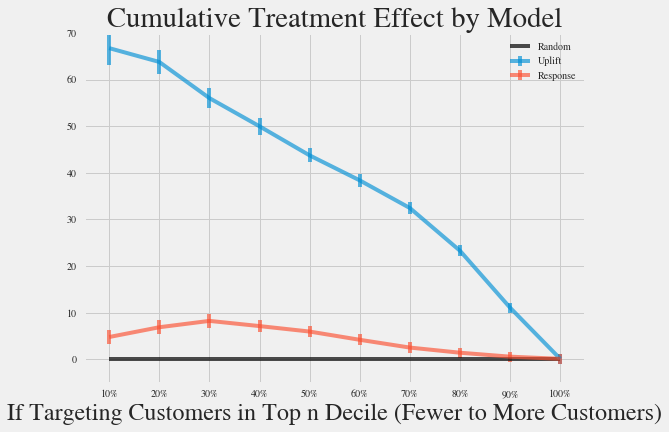

In [401]:
response_cumul_treatment_effect['group'] = [str(num*10)+'%' for num in range(1,11)]
uplift_cumul_treatment_effect['group'] = [str(num*10)+'%' for num in range(1,11)]

plt.figure(figsize=(8,6))
plt.errorbar(
    uplift_cumul_treatment_effect['group'], 
    uplift_cumul_treatment_effect['cumul_treatment_effect']*100,
    uplift_cumul_treatment_effect['standard_error']*100*1.96,
    label='Uplift',
    alpha=0.65
)
plt.errorbar(
    response_cumul_treatment_effect['group'], 
    response_cumul_treatment_effect['cumul_treatment_effect']*100,
    response_cumul_treatment_effect['standard_error']*100*1.96,
    label='Response',
    alpha=0.65
)

plt.ylim(-5,70)
plt.xlabel("If Targeting Customers in Top n Decile (Fewer to More Customers)")
plt.hlines(average_treatment_effect, 0, 9, label='Random', alpha=0.75)
plt.xlim(-0.5,9.5)
plt.title("Cumulative Treatment Effect by Model")
plt.legend();

del response_cumul_treatment_effect, uplift_cumul_treatment_effect

In [402]:

results_df['uplift_decile'].value_counts().sort_index(ascending=False).reset_index().\
rename(columns={'uplift_decile': 'number_of_customers', 'index': 'uplift_decile'})

,uplift_decile,number_of_customers
0,"(1.13, 2.0]",3805
1,"(0.636, 1.13]",3804
2,"(0.338, 0.636]",3804
3,"(0.155, 0.338]",3805
4,"(0.0402, 0.155]",3803
5,"(-0.0776, 0.0402]",3796
6,"(-0.293, -0.0776]",3815
7,"(-0.667, -0.293]",3804
8,"(-1.223, -0.667]",3805
9,"(-2.001, -1.223]",3805


In [403]:
features

['recency',
 'history_segment',
 'history',
 'mens',
 'womens',
 'zip_code',
 'newbie',
 'channel',
 'Treatment',
 'Outcome']

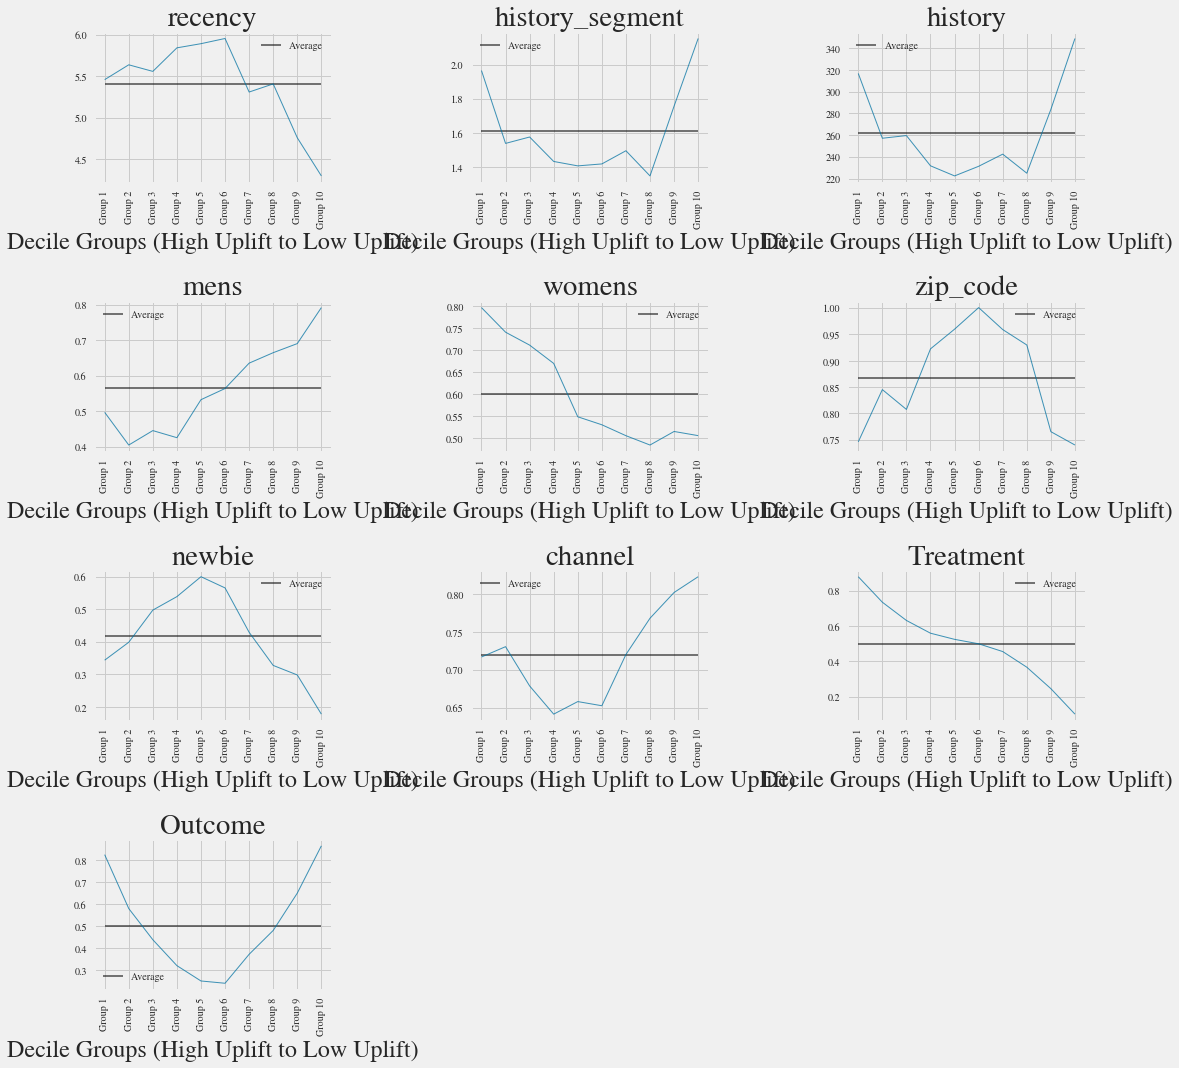

In [356]:
# feats = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
feats = features
avg_feat_per_decile = results_df.groupby("uplift_decile")[feats[0]].mean().sort_index(ascending=False).reset_index()
for feat in feats[1:]:
    avg_feat_per_decile[feat] = results_df.groupby("uplift_decile")[feat].mean().sort_index(ascending=False).values
avg_feat_per_decile['group'] = ['Group ' + str(num) for num in range(1,11)]
avg_feat_per_decile

# print(f"Zip code label encodings: {zip_code_le.classes_}")
# print(f"Channel label encodings: {channel_le.classes_}")

fig = plt.figure(figsize=(16,18))
for idx, feat in enumerate(feats):
    ax = fig.add_subplot(5,3,idx+1)
    ax.set_xlabel('Decile Groups (High Uplift to Low Uplift)')
    ax.set_title(feat)
    ax.plot(avg_feat_per_decile.group, avg_feat_per_decile[feat], 'bx-', linewidth=1, alpha=0.75)
    plt.xticks(rotation='vertical')
    plt.hlines(results_df[feat].mean(), 0, 9, label='Average', alpha=0.75, linewidth=1.5)
    plt.legend()
plt.tight_layout()

In [404]:
mens_df = df[df.segment!='Womens E-Mail'].copy()
mens_df.segment.replace({'Mens E-Mail':1, 'No E-Mail':0}, inplace=True)
mens_df.drop(columns=['conversion', 'spend'], inplace=True)
mens_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit
1,6,2,329.08,1,1,1,1,1,0,0
3,9,4,675.83,1,0,1,1,1,1,0
8,9,4,675.07,1,1,1,1,0,1,0
13,2,1,101.64,0,1,2,0,1,1,1
14,4,2,241.42,0,1,1,1,2,0,0


In [405]:
# mens_df.zip_code = LabelEncoder().fit_transform(mens_df.zip_code)
# mens_df.channel = LabelEncoder().fit_transform(mens_df.channel)
mens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)
mens_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,Treatment,Outcome
1,6,2,329.08,1,1,1,1,1,0,0
3,9,4,675.83,1,0,1,1,1,1,0
8,9,4,675.07,1,1,1,1,0,1,0
13,2,1,101.64,0,1,2,0,1,1,1
14,4,2,241.42,0,1,1,1,2,0,0


In [ ]:
# mens_df.drop(columns=['spend_segment'], inplace=True)

In [ ]:
# mens_df = pd.get_dummies(mens_df)
# mens_df.rename(columns={'segment':'Treatment', 'visit':'Outcome'}, inplace=True)
# mens_df.head()

In [ ]:
# mens_df.drop(columns=['spend_segment_0', 'spend_segment_1', 'spend_segment_2',
#                         'spend_segment_3', 'spend_segment_4', 'spend_segment_5'], inplace=True)


In [406]:
Train, test, Train_target, test_target = train_test_split(mens_df.drop(['Outcome'], axis=1), 
                                                          mens_df.Outcome, test_size=0.0001, 
                                                          stratify=mens_df.Outcome, 
                                                          random_state=42)
df_train = pd.concat([Train, Train_target], axis=1)
df_test = pd.concat([test, test_target], axis=1)

print(len(df_train))
print(len(df_test))

42608
5


In [407]:
features = list(mens_df.columns)

In [408]:
# test_results(promotion_strategy, df_train, features)

In [409]:
# test_results(promotion_strategy, df_test, features)

In [410]:
# response = []

# for index, row in df_train.iterrows():
#     if (row['Outcome'] == 1) and (row['Treatment']==1):
#         response.append(1.0)
#     else:
#         response.append(0.0)
        
# df_train['response'] = response
# df_train


response = []
for index, row in df_train.iterrows():
    if (row['Treatment'] == 1) & (row['Outcome'] == 1):
        # TR group
        response.append(0)
    elif (row['Treatment'] == 0) & (row['Outcome'] == 1):
        # CR group
        response.append(1)
    elif (row['Treatment'] == 1) & (row['Outcome'] == 0):
        # TN group
        response.append(2)
    else: #CN group
        response.append(3)

df_train['response'] = response

In [411]:
y_not_to_include = ['response']
list_of_total_features = list(train.columns)
features = list(filter(lambda x: x not in y_not_to_include, list_of_total_features))
features

['recency',
 'history_segment',
 'history',
 'mens',
 'womens',
 'zip_code',
 'newbie',
 'channel',
 'Treatment',
 'Outcome']

In [412]:
train, valid = train_test_split(df_train, test_size=0.001,
                                random_state=42, 
                                stratify=df_train.Outcome)


In [413]:
# generate features and labels
Y_train = train['response']
X_train = train[features]

Y_valid = valid['response']
X_valid = valid[features]

In [414]:
# y =  X_train['Outcome']
# del X_train['Outcome']


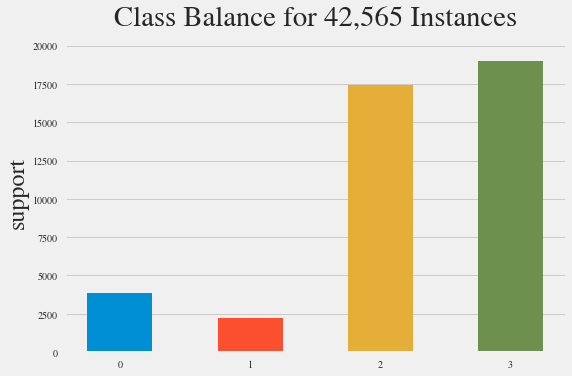

In [416]:
class_balance(Y_train);

In [419]:

from imblearn.over_sampling import SMOTENC
# up sample only the train dataset with SMOTE
# sm = SMOTENC(categorical_features=[0,1,3,4,5,6,7,8,9,10,11,12], random_state=42)#, ratio = 1.0)
sm = SMOTENC(categorical_features=[1,3,4,5,6,7,8], random_state=42)#, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=list(X_train.columns))
Y_train_upsamp = pd.Series(Y_train_upsamp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


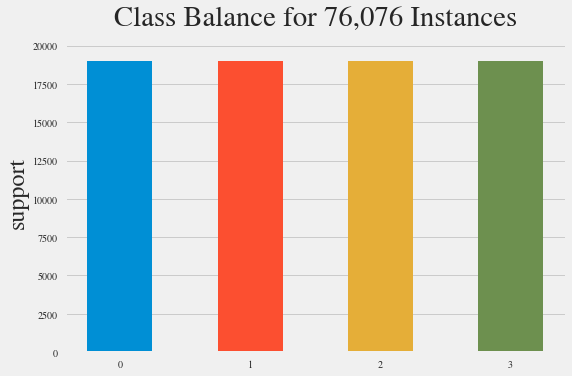

In [423]:
class_balance(Y_train_upsamp);

In [424]:
mens_df = pd.concat([X_train_upsamp, Y_train_upsamp], axis=1)
# mens_df.rename(columns={0:'Outcome'}, inplace=True)
del mens_df[0]
mens_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,Treatment,Outcome
0,10.0,0.0,89.96,1.0,0.0,2.0,1.0,0.0,1.0,0.0
1,10.0,0.0,60.06,1.0,0.0,2.0,1.0,1.0,0.0,0.0
2,12.0,0.0,50.30,1.0,0.0,2.0,1.0,0.0,0.0,0.0
3,1.0,1.0,154.73,1.0,0.0,2.0,0.0,1.0,0.0,0.0
4,12.0,0.0,76.18,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [425]:

state = 10

up2 = TransformedOutcome(mens_df,
                         col_treatment='Treatment',
                         col_outcome='Outcome',
                         stratify=mens_df['Treatment'],
                         test_size=0.5,
                         continuous_outcome=False,
                         sklearn_model=RandomForestRegressor,
                         random_state=state
                        )

In [426]:
# best_params = {
#     'random_state': 5,
#     'n_estimators': 126,
#     'max_features': 'sqrt',
#     'max_depth': 4
# }

# up2.fit(**best_params)

up2.randomized_search(param_distributions={
    'n_estimators': [5,10,50,100,1000],
    'max_depth':[2,5,10,20],
    'min_samples_split':[10,100,1000,10000],
    'max_features':['sqrt', 'auto']}, refit=True)
up2.fit(**up2.rand_search_.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, min_samples_split=1000, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_samples_split=1000, max_features=sqrt, max_depth=10, score=0.148, total=   0.7s
[CV] n_estimators=50, min_samples_split=1000, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=1000, max_features=sqrt, max_depth=10, score=0.109, total=   0.7s
[CV] n_estimators=50, min_samples_split=1000, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=1000, max_features=sqrt, max_depth=10, score=0.117, total=   0.7s
[CV] n_estimators=50, min_samples_split=1000, max_features=sqrt, max_depth=10 
[CV]  n_estimators=50, min_samples_split=1000, max_features=sqrt, max_depth=10, score=0.117, total=   0.6s
[CV] n_estimators=50, min_samples_split=1000, max_features=sqrt, max_depth=10 
[CV]  n_estimators=50, min_samples_split=1000, max_features=sqrt, max_depth=10, score=0.146, total=   0.8s
[CV] n_estimators=5, min_samples_split=100, max_features=sqrt, max_depth=2 
[CV]  n_estimators=5, min_samples_split=100, max_features=sqrt, max_depth=2, score=0.075, total=   0.1s
[CV] n_estimators=5, min_samples_split=100, max_features=sqrt, max_depth=2 
[CV]  n_estimators=5, min_samples_split=100, max_features=sqrt, max_depth=2, score=0.039, total=   0.1s
[CV] n_estimators=5, min_samples_split=100, max_features=sqrt, max_depth=2 
[CV]  n_estimators=5, min_samples_split=100, max_features=sqrt, max_depth=2, score=0.

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.2min finished


In [427]:
up2.rand_search_.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_split': 100,
 'n_estimators': 50}

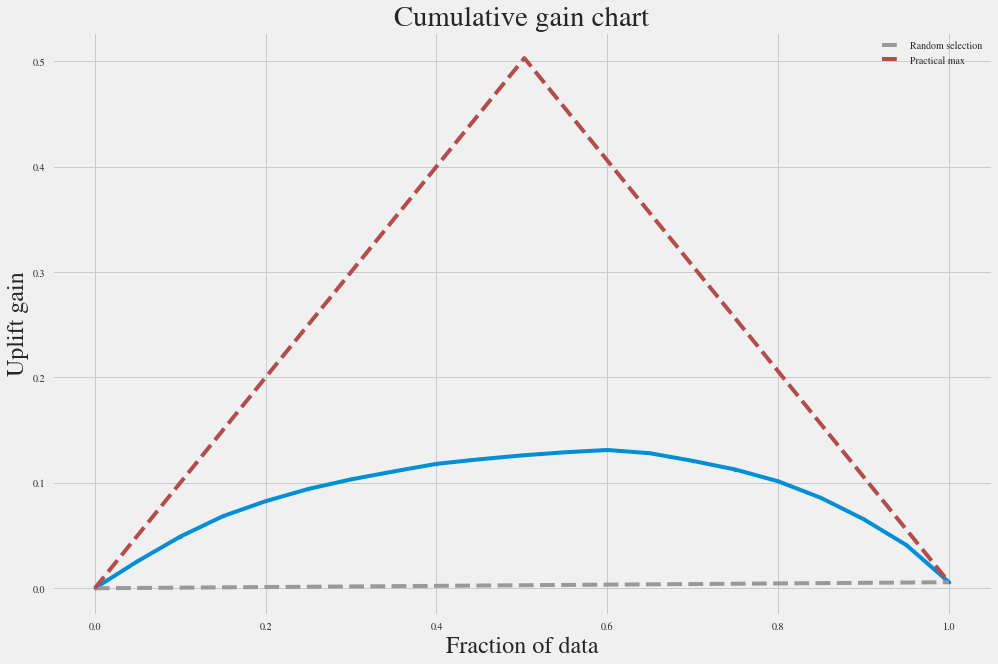

In [428]:
up2.plot(plot_type='cgains', show_practical_max=True)

Text(0.5, 1.0, 'Qini Curve (Test)')

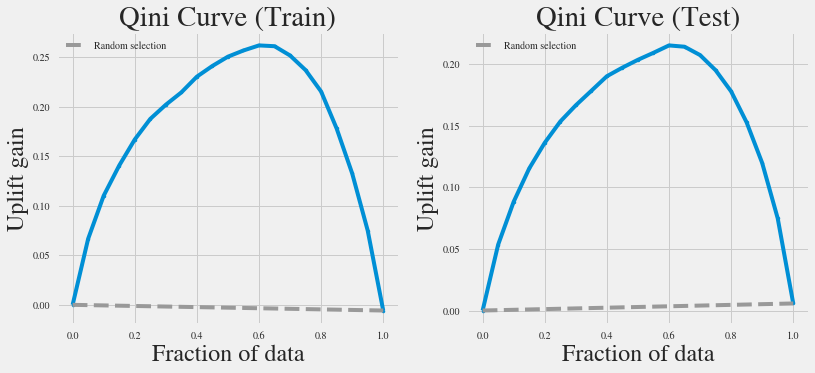

In [429]:
# Plot Train/Test Qini Curve
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
up2.train_results_.plot('qini', ax=ax, show_random_selection=True)
ax.set_title("Qini Curve (Train)")
ax = fig.add_subplot(122)
up2.test_results_.plot('qini', ax=ax, show_random_selection=True)
ax.set_title("Qini Curve (Test)")

In [430]:
average_treatment_effect = visit_rate_ate(up2.df_test, test_set=True)
print("Qini AUC: {:.5f}".format(up2.train_results_.Q_qini))
print("Qini AUC: {:.5f}".format(up2.test_results_.Q_qini))

Test set visit rate uplift: 0.57%
Qini AUC: 0.18745
Qini AUC: 0.15038


In [431]:

response_train_df = up2.df_train[up2.df_train.Treatment==1].copy()
response_test_df = up2.df_test.copy()

response_train_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)
response_test_df.drop(columns = ['Treatment', 'TransformedOutcome'], inplace=True)

response_train_label = response_train_df.Outcome
response_test_label = response_test_df.Outcome
response_train_df = response_train_df.drop(columns='Outcome')
response_test_df = response_test_df.drop(columns='Outcome')

gs = GridSearchCV(
    RandomForestClassifier(n_estimators=1000),
    param_grid={'max_depth':[3,5,7,9,11]},
    scoring='accuracy',
    n_jobs=4,
    iid=False,
    cv=5
)
gs.fit(response_train_df, response_train_label)
response_model = RandomForestClassifier(n_estimators=1000, **gs.best_params_)
response_model.fit(response_train_df, response_train_label)
y_pred_response = response_model.predict_proba(response_test_df)[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [432]:
# Test set dataframe containing uplift/response scores scorted into deciles
results_df = up2.df_test.copy()
results_df['response'] = y_pred_response
results_df['uplift'] = up2.transformed_y_test_pred
results_df['response_decile'] = pd.qcut(y_pred_response, 10)
results_df['uplift_decile'] = pd.qcut(up2.transformed_y_test_pred, 10)

results_df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,Treatment,Outcome,TransformedOutcome,response,uplift,response_decile,uplift_decile
39508,5.00000,1.0,128.720000,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0.137268,0.108348,"(0.0226, 0.209]","(0.0717, 0.127]"
24929,8.00000,1.0,137.880000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0.465517,0.153770,"(0.433, 0.487]","(0.127, 0.193]"
28930,4.00000,2.0,207.600000,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2,0.486133,0.321421,"(0.433, 0.487]","(0.281, 0.836]"
65030,3.21089,1.0,104.062999,1.0,0.0,2.0,0.0,1.0,0.0,1.0,-2,0.527570,-0.239404,"(0.487, 0.537]","(-0.308, -0.188]"
142,1.00000,2.0,200.400000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0,0.534386,0.162683,"(0.487, 0.537]","(0.127, 0.193]"


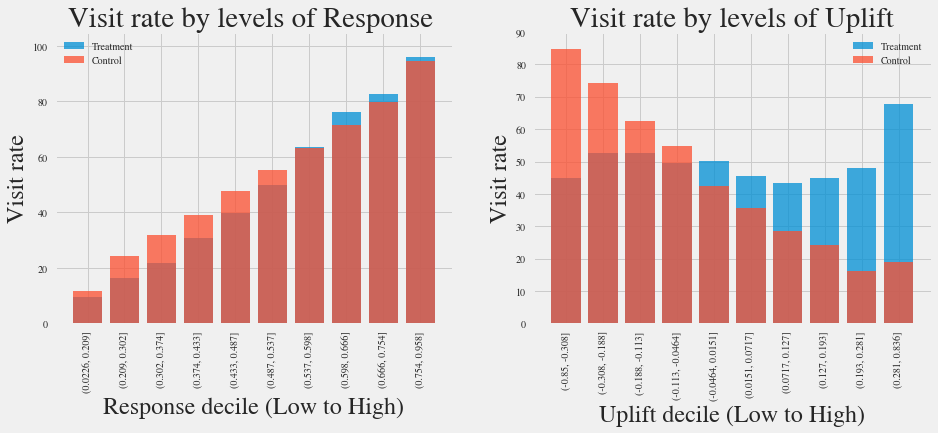

In [437]:
response_visit_rates_t, response_visit_rates_c = compute_visit_rates(results_df, for_response=True)
uplift_visit_rates_t, uplift_visit_rates_c = compute_visit_rates(results_df, for_response=False)

fig = plt.figure(figsize=(14,5))

ax1 = fig.add_subplot(121)
ax1.bar(response_visit_rates_t['response_decile'], response_visit_rates_t['visit_rate'], label='Treatment', alpha=0.75)
ax1.bar(response_visit_rates_c['response_decile'], response_visit_rates_c['visit_rate'], label='Control', alpha=0.75)
ax1.set_ylabel("Visit rate")
ax1.set_xlabel("Response decile (Low to High)")
ax1.legend()
ax1.set_title("Visit rate by levels of Response ")
plt.xticks(rotation='vertical')
ax1.set_ylim(0,105)

ax2 = fig.add_subplot(122)
ax2.bar(uplift_visit_rates_t['uplift_decile'], uplift_visit_rates_t['visit_rate'], label='Treatment', alpha=0.75)
ax2.bar(uplift_visit_rates_c['uplift_decile'], uplift_visit_rates_c['visit_rate'], label='Control', alpha=0.75)
ax2.set_ylabel("Visit rate")
ax2.set_xlabel("Uplift decile (Low to High)")
ax2.legend()
ax2.set_title("Visit rate by levels of Uplift")
plt.xticks(rotation='vertical')
ax2.set_ylim(0,90);

del response_visit_rates_t, response_visit_rates_c, uplift_visit_rates_t, uplift_visit_rates_c

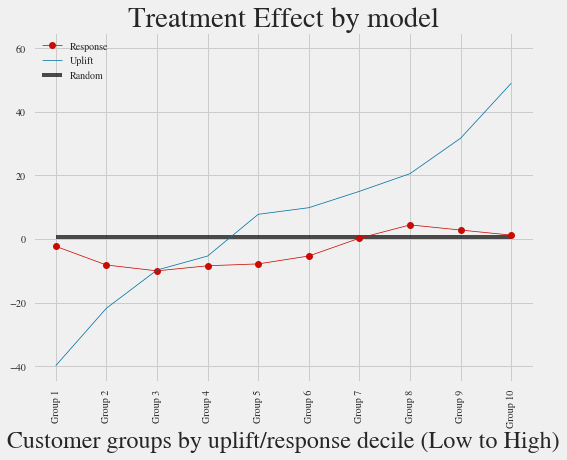

In [434]:
response_treatment_effect = compute_treatment_effect(results_df, for_response=True)
uplift_treatment_effect = compute_treatment_effect(results_df, for_response=False)
response_treatment_effect['group'] = ['Group ' + str(num) for num in range(1,11)]
uplift_treatment_effect['group'] = ['Group ' + str(num) for num in range(1,11)]

plt.figure(figsize=(8,6))
plt.plot(response_treatment_effect['group'], response_treatment_effect['treatment_effect'], 'ro-', linewidth=0.75, label='Response')
plt.plot(uplift_treatment_effect['group'], uplift_treatment_effect['treatment_effect'], 'bx-', linewidth=0.75, label='Uplift')
plt.ylim(-45,65)
plt.xticks(rotation='vertical')
plt.xlabel("Customer groups by uplift/response decile (Low to High)")
plt.title("Treatment Effect by model")
plt.hlines(average_treatment_effect, 0, 9, label='Random', alpha=0.75)
plt.legend();

del response_treatment_effect, uplift_treatment_effect

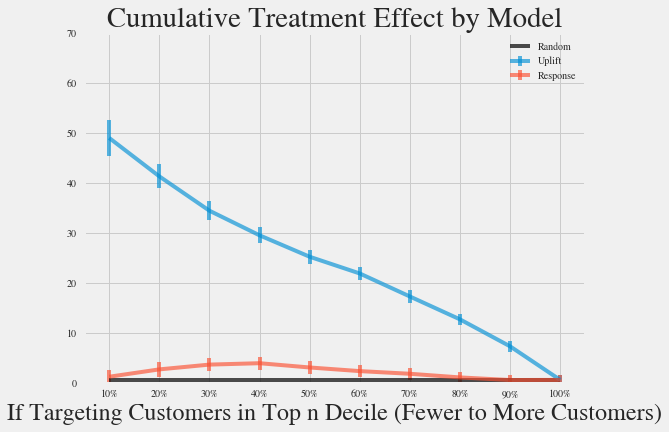

In [435]:
response_cumul_treatment_effect = cumulative_treatment_effect(results_df, for_response=True)
uplift_cumul_treatment_effect = cumulative_treatment_effect(results_df, for_response=False)

response_cumul_treatment_effect['group'] = [str(num*10)+'%' for num in range(1,11)]
uplift_cumul_treatment_effect['group'] = [str(num*10)+'%' for num in range(1,11)]

plt.figure(figsize=(8,6))
plt.errorbar(
    uplift_cumul_treatment_effect['group'], 
    uplift_cumul_treatment_effect['cumul_treatment_effect']*100,
    uplift_cumul_treatment_effect['standard_error']*100*1.96,
    label='Uplift',
    alpha=0.65
)
plt.errorbar(
    response_cumul_treatment_effect['group'], 
    response_cumul_treatment_effect['cumul_treatment_effect']*100,
    response_cumul_treatment_effect['standard_error']*100*1.96,
    label='Response',
    alpha=0.65
)

plt.ylim(0,70)
plt.xlabel("If Targeting Customers in Top n Decile (Fewer to More Customers)")
plt.hlines(average_treatment_effect, 0, 9, label='Random', alpha=0.75)
plt.xlim(-0.5,9.5)
plt.title("Cumulative Treatment Effect by Model")
plt.legend();

del response_cumul_treatment_effect, uplift_cumul_treatment_effect

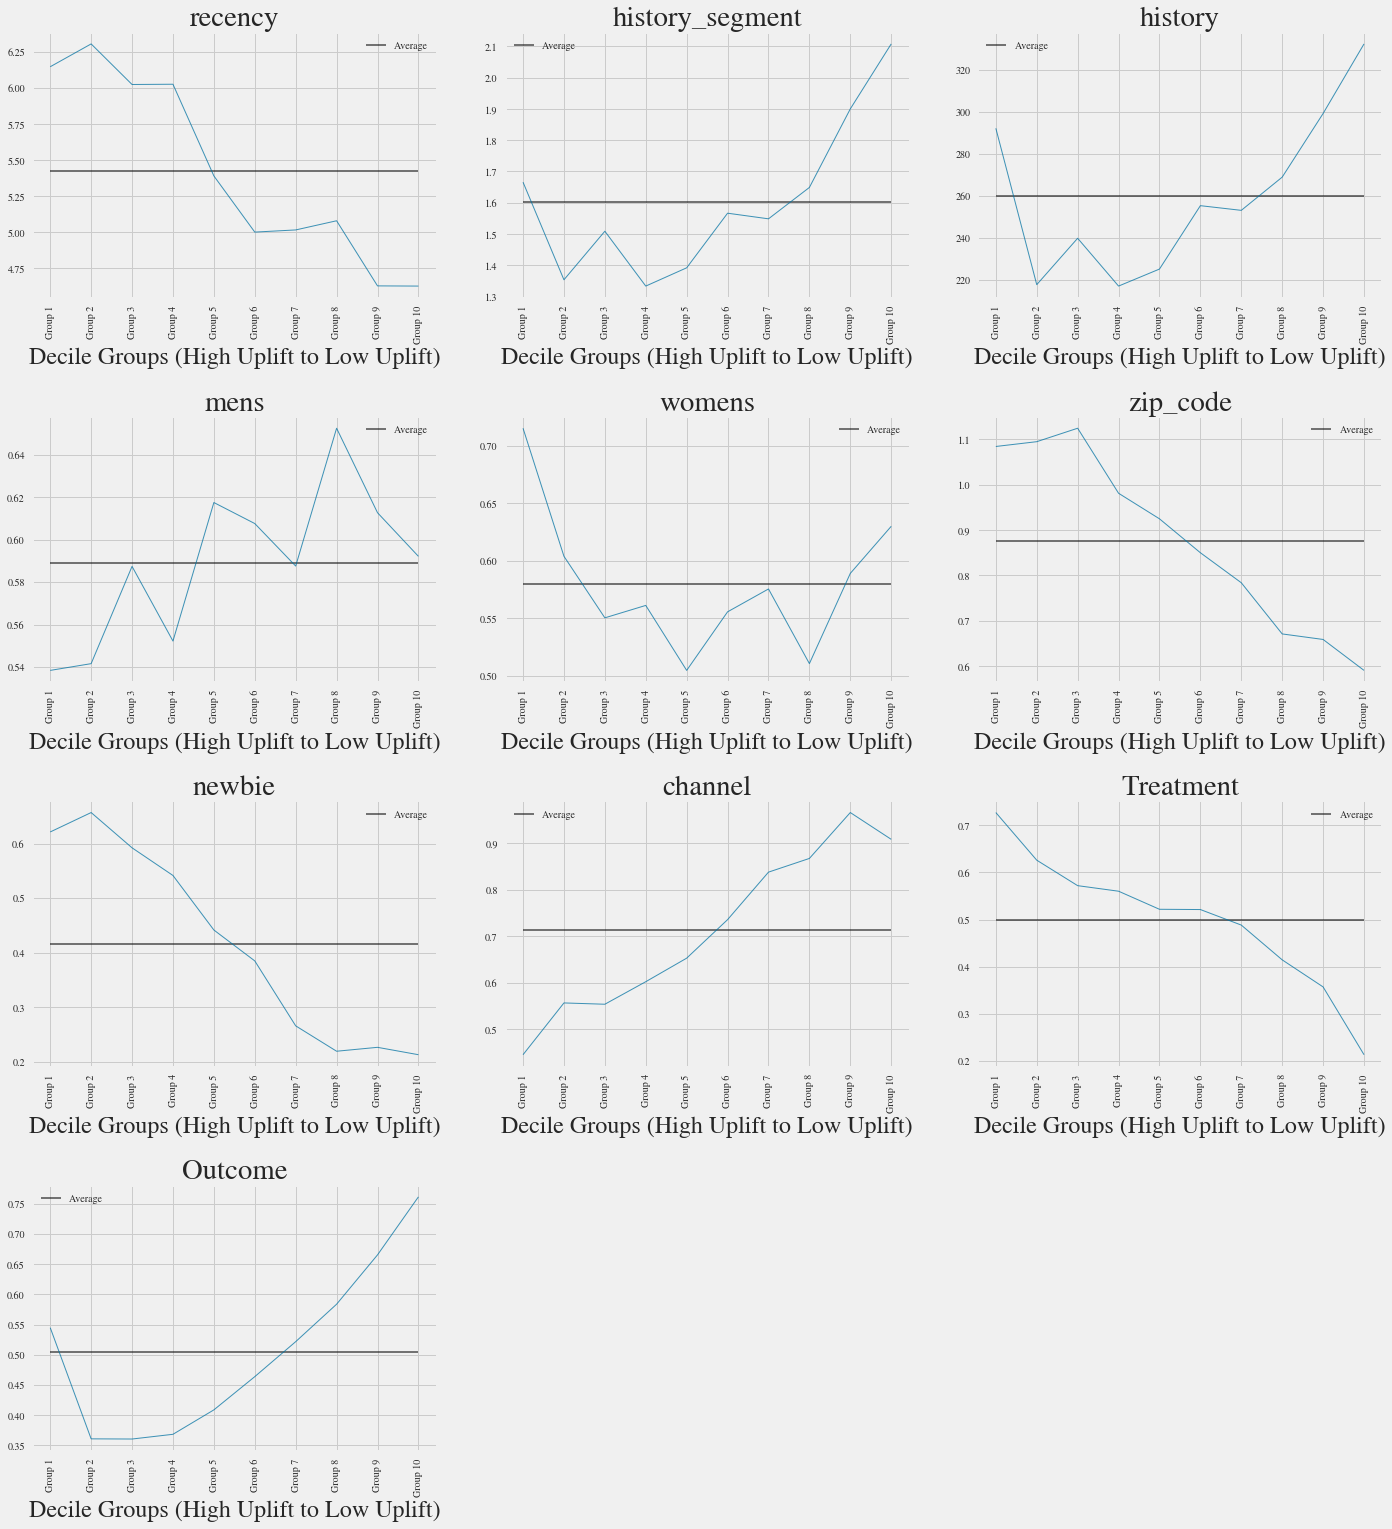

In [438]:
# feats = ['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
feats = features
avg_feat_per_decile = results_df.groupby("uplift_decile")[feats[0]].mean().sort_index(ascending=False).reset_index()
for feat in feats[1:]:
    avg_feat_per_decile[feat] = results_df.groupby("uplift_decile")[feat].mean().sort_index(ascending=False).values
avg_feat_per_decile['group'] = ['Group ' + str(num) for num in range(1,11)]
avg_feat_per_decile

# print(f"Zip code label encodings: {zip_code_le.classes_}")
# print(f"Channel label encodings: {channel_le.classes_}")

fig = plt.figure(figsize=(20,26))
for idx, feat in enumerate(feats):
    ax = fig.add_subplot(5, 3, idx+1)
    ax.set_xlabel('Decile Groups (High Uplift to Low Uplift)')
    ax.set_title(feat)
    ax.plot(avg_feat_per_decile.group, avg_feat_per_decile[feat], 'bx-', linewidth=1, alpha=0.75)
    plt.xticks(rotation='vertical')
    plt.hlines(results_df[feat].mean(), 0, 9, label='Average', alpha=0.75, linewidth=1.5)
    plt.legend()
plt.tight_layout()